In [6]:
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
from datetime import datetime
from tqdm import tqdm  # Using notebook version of tqdm
from skimage.metrics import structural_similarity as ssim_fc

# Suppress Qt warnings in some environments
os.environ["QT_QPA_PLATFORM"] = "offscreen"

image_size = 256

In [7]:
# ==========================================================
# 1. Image Loading & Preprocessing
# ==========================================================
def load_and_preprocess(img_path, image_size=256):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read image or file is corrupted: {img_path}")
        
    img = cv2.resize(img, (image_size, image_size))
    
    if len(img.shape) == 2:
        gray = img
        rgb_uint8 = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    elif len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rgb_uint8 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif len(img.shape) == 3 and img.shape[2] == 4:
        bgr = img[:, :, :3]
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        rgb_uint8 = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError(f"Unsupported image shape: {img.shape}")
    
    gray_float = (gray / 255.0).astype(np.float32)
    return gray_float, rgb_uint8

def check_transform_validity(image, affine_matrix, black_thresh=0.05, rot_thresh_deg=45):
    if image is None: return True, "Image None"
    mean_val = np.mean(image)
    if mean_val < black_thresh:
        return True, f"Too Dark (Mean={mean_val:.3f})"
    if affine_matrix is None: return True, "Matrix None"
    angle_rad = np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0])
    angle_deg = np.degrees(angle_rad)
    if abs(angle_deg) > rot_thresh_deg:
        return True, f"Excessive Rotation ({angle_deg:.1f} deg)"
    return False, "OK"

# ==========================================================
# 2. Metrics & Math Helpers (PURE NUMPY)
# ==========================================================
def mse(image1, image2):
    return np.mean(np.square(image1 - image2))

def tre(points1, points2):
    return np.mean(np.sqrt(np.sum((points1 - points2)**2, axis=0)))

def ssim_color_aware(image1, image2):
    kwargs = {'data_range': image2.max() - image2.min()}
    if image1.ndim == 3:
        kwargs['channel_axis'] = -1
    try:
        output = ssim_fc(image1, image2, **kwargs)
    except ValueError:
        output = 0.0
    return -output

def affine_to_DVF_numpy(affine_matrix, H, W):
    if affine_matrix is None:
        return np.zeros((1, 2, H, W))
    
    x = np.arange(W)
    y = np.arange(H)
    xx, yy = np.meshgrid(x, y)
    
    ones = np.ones_like(xx)
    coords = np.vstack([xx.ravel(), yy.ravel(), ones.ravel()])
    
    new_coords = affine_matrix @ coords
    
    disp_x = new_coords[0, :] - xx.ravel()
    disp_y = new_coords[1, :] - yy.ravel()
    
    disp = np.stack([disp_x.reshape(H, W), disp_y.reshape(H, W)], axis=0)
    return disp[np.newaxis, ...] 

# ==========================================================
# 3. Visualization Helpers
# ==========================================================
def overlay_points_color(image, points, color=(0, 255, 0), radius=5):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image.max() <= 2.0:
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8).copy()
    if points is not None and len(points) > 0:
        try:
            for point in points.T:
                x, y = int(point[0]), int(point[1])
                cv2.circle(image, (x, y), radius, color, -1)
        except Exception: pass
    return image

def draw_lines_one_image_color(image, points1, points2, line_thickness=1, opacity=0.5, line_color=None):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image.max() <= 2.0:
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8).copy()

    bright_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255), (255, 128, 0)]
    if points1 is not None and points2 is not None and len(points1) > 0 and len(points2) > 0:
        for pt1, pt2 in zip(points1.T, points2.T):
            x1, y1 = int(pt1[0]), int(pt1[1])
            x2, y2 = int(pt2[0]), int(pt2[1])
            color_to_use = line_color if line_color is not None else random.choice(bright_colors)
            cv2.line(image, (x1, y1), (x2, y2), color_to_use, line_thickness)
            overlay = image.copy()
            cv2.line(overlay, (x1, y1), (x2, y2), color_to_use, line_thickness)
            cv2.addWeighted(overlay, opacity, image, 1 - opacity, 0, image)
    return image

def create_checkerboard_color(image1, image2):
    checkerboard = np.zeros_like(image1)
    width = checkerboard.shape[1]
    tile_size = width / 10
    for i in range(checkerboard.shape[0]):
        for j in range(checkerboard.shape[1]):
            num = (math.floor(i / tile_size) + math.floor(j / tile_size)) % 2
            if num == 0: checkerboard[i, j] = image1[i, j]
            else: checkerboard[i, j] = image2[i, j]
    return checkerboard

def signaturebar_gray(fig, text, fontsize=10, pad=5, xpos=20, ypos=7.5, rect_kw={"facecolor": "gray", "edgecolor": None}, text_kw={"color": "w"}):
    w, h = fig.get_size_inches()
    height = ((fontsize + 2 * pad) / 72.) / h
    rect_inner = plt.Rectangle((0, 0), 1, height, transform=fig.transFigure, clip_on=False, **rect_kw)
    fig.axes[0].add_patch(rect_inner)
    fig.text(xpos / 72. / h, ypos / 72. / h, text, fontsize=fontsize, **text_kw)
    fig.subplots_adjust(bottom=fig.subplotpars.bottom + height)
    return fig

def DL_affine_plot_color(name, dir_name, image1_name, image2_name, image1, image2, image3,
                       matches1, matches2, matches3, desc1, desc2, affine_params_true=None, 
                       affine_params_predict=None, heatmap1=None, heatmap2=None, plot=0, alpha=0.3):
    try:
        mse_before = mse(matches1, matches2)
        tre_before = tre(matches1, matches2)
        mse12 = mse(matches3, matches2)
        tre12 = tre(matches3, matches2)
    except:
        mse_before, tre_before, mse12, tre12 = np.nan, np.nan, np.nan, np.nan

    mse12_image_before = mse(image1, image2)
    mse12_image = mse(image3, image2)
    ssim12_image_before = ssim_color_aware(image1, image2)
    ssim12_image = ssim_color_aware(image3, image2)

    if plot == 1:
        fig, axes = plt.subplots(subplot_kw={'projection': None}, num=None, figsize=(20, 10))
        fig, axes = plt.subplot_mosaic("BCFD;AGHE", figsize=(20, 10))

        red = (255, 0, 0); green = (0, 255, 0); orange = (255, 165, 0); blue = (0, 0, 155)
        
        overlaid1 = overlay_points_color(image1.copy(), matches1, color=red, radius=1)
        overlaid2 = overlay_points_color(image2.copy(), matches2, color=green, radius=1)
        overlaid3 = overlay_points_color(image3.copy(), matches3, color=orange, radius=1)
        overlaidD = overlay_points_color(overlaid2.copy(), matches3, color=orange, radius=1)
        overlaidD = overlay_points_color(overlaidD.copy(), matches1, color=red, radius=1)
        overlaidE = overlay_points_color(overlaid2.copy(), matches3, color=orange, radius=1)
        overlaidH = overlay_points_color(overlaid2.copy(), matches1, color=red, radius=1)

        axes["F"].imshow(overlaid3)
        axes["F"].set_title(f"Warped")
        axes["F"].axis('off'); axes['F'].grid(True)

        axes["B"].imshow(overlaid1)
        try: axes["B"].set_title(f"Source,\n{matches1.shape}, {matches2.shape}, {matches3.shape}") 
        except: axes["B"].set_title(f"Source,\nMSE: {mse12_image_before:.4f} SSIM: {ssim12_image_before:.4f}")
        axes["B"].axis('off'); axes['B'].grid(True)

        axes["C"].imshow(overlaid2)
        if affine_params_true is not None: axes["C"].set_title(f"Target, {affine_params_true}")
        else: axes["C"].set_title(f"Target (unsupervised)")
        axes["C"].axis('off'); axes['C'].grid(True)
        
        try:
            imgH = draw_lines_one_image_color(overlaidH, matches2, matches1, line_color=blue)
            axes["H"].imshow(imgH)
        except: axes["H"].imshow(overlaidH)
        axes["H"].set_title(f"Before, Error lines. MSE: {mse_before:.4f}, TRE: {tre_before:.4f}")
        axes["H"].axis('off')
        
        try:
            imgD = draw_lines_one_image_color(overlaidD, matches3, matches1, line_color=blue)
            axes["D"].imshow(imgD)
        except: axes["D"].imshow(overlaidD)

        skip = 8
        X, Y = np.meshgrid(np.arange(0, 256), np.arange(0, 256))
        
        if affine_params_predict is not None:
            try:
                DVF = affine_to_DVF_numpy(affine_params_predict, 256, 256)[0]
                U = -1 * DVF[0, :, :]
                V = 1 * DVF[1, :, :]
                axes["D"].quiver(X[::skip, ::skip], Y[::skip, ::skip], U[::skip, ::skip], V[::skip, ::skip], 
                                 color='r', scale=1, scale_units='xy', alpha=alpha)
            except Exception as e: pass

        axes["D"].set_xlim(0, 255); axes["D"].set_ylim(255, 0)
        try: axes["D"].set_title(f"Source -> Warped, Xformation.\nMSE: {mse(matches1, matches3):.4f}, TRE: {tre(matches1, matches3):.4f}")
        except: axes["D"].set_title(f"Source -> Warped, Xformation.")
        axes["D"].axis('off')

        try:
            imgE = draw_lines_one_image_color(overlaidE, matches2, matches3, line_color=blue)
            axes["E"].imshow(imgE)
        except: axes["E"].imshow(overlaidE)
        axes["E"].set_title(f"After, Error lines. MSE: {mse12:.4f}, TRE: {tre12:.4f}")
        axes["E"].axis('off')

        checkerboard1 = create_checkerboard_color(image1, image2)
        axes["A"].imshow(checkerboard1)
        axes["A"].set_title(f"Original - Target, MSE: {mse12_image_before:.4f}, SSIM: {ssim12_image_before:.4f}")
        axes["A"].axis('off')

        checkerboard2 = create_checkerboard_color(image3, image2)
        axes["G"].imshow(checkerboard2)
        axes["G"].set_title(f"Warped - Target, MSE: {mse12_image:.4f}, SSIM: {ssim12_image:.4f}")
        axes["G"].axis('off')
        
        plt.tight_layout()  
        if not os.path.exists(dir_name): os.makedirs(dir_name) 
        save_file_name = os.path.join(dir_name, f"{name}_{image1_name}.png")

        if os.path.exists(save_file_name):
            suffix = 1
            while True:
                new_file_name = os.path.join(dir_name, f"{name}_{image1_name}_{suffix}.png")
                if not os.path.exists(new_file_name):
                    save_file_name = new_file_name
                    break
                suffix += 1

        signaturebar_gray(fig, f"{name}: {image2_name}", fontsize=20, pad=5, xpos=20, ypos=7.5,
                rect_kw={"facecolor": "gray", "edgecolor": None}, text_kw={"color": "w"})
        fig.savefig(save_file_name)
        plt.close(fig) # Prevent Jupyter from displaying 100 images inline automatically

    return matches3, mse_before, mse12, tre_before, tre12, mse12_image_before, mse12_image, ssim12_image_before, ssim12_image

In [8]:
def run_sift_match(src_gray, tgt_gray, nn_thresh):
    """Extract and match keypoints using SIFT."""
    
    src_uint8 = (src_gray * 255).astype(np.uint8)
    tgt_uint8 = (tgt_gray * 255).astype(np.uint8)
    
    sift = cv2.SIFT_create()
    kp1_cv, desc1 = sift.detectAndCompute(src_uint8, None)
    kp2_cv, desc2 = sift.detectAndCompute(tgt_uint8, None)
    
    heatmap1, heatmap2 = None, None 
    
    if desc1 is None or desc2 is None or len(kp1_cv) < 3 or len(kp2_cv) < 3:
        return np.array([]), np.array([]), heatmap1, heatmap2
        
    bf = cv2.BFMatcher()
    
    def match_sift_ratio(d1, d2, ratio):
        matches_knn = bf.knnMatch(d1, d2, k=2)
        good = []
        for m_n in matches_knn:
            if len(m_n) == 2:
                m, n = m_n
                if m.distance < ratio * n.distance:
                    good.append(m)
        return good
        
    threshold = nn_thresh
    good_matches = match_sift_ratio(desc1, desc2, threshold)
    
    while len(good_matches) < 4 and threshold < 0.95:
        threshold += 0.1
        good_matches = match_sift_ratio(desc1, desc2, threshold)
        
    if len(good_matches) < 3:
        return np.array([]), np.array([]), heatmap1, heatmap2
        
    m1 = np.float32([kp1_cv[m.queryIdx].pt for m in good_matches])
    m2 = np.float32([kp2_cv[m.trainIdx].pt for m in good_matches])
    
    return m1, m2, heatmap1, heatmap2

In [ ]:
# =================================================================
# ⚙️ CONFIGURATION 
# =================================================================

# Option 1: Provide a direct list of image paths [source1, target1, source2, target2, ...]
# Leave empty [] if you want to use the CSV file instead.
img_list = ['test_images/NIR_M121HW_0.jpg', 'test_images/RGB_M121LW_0.jpg'] 

# Option 2: Provide a path to a CSV or TXT file (src, tgt per line)
img_file = "my_pairs.csv" 

# Thresholds and Methods
nn_threshold = 0.7
method = 'RANSAC' # Choose between 'RANSAC' or 'LMEDS'

# Saving Options
save_images = 1   # 0: Save only plot | 1: Save plot AND original color images

# =================================================================

Found 1 pairs to process.
Using Pure OpenCV/NumPy SIFT Pipeline...


Processing Pairs: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Finished processing. Results saved to output/SIFT_Standalone_Jupyter_20260223-173435
CSV Log generated at: output/SIFT_Standalone_Jupyter_20260223-173435/results_log.csv


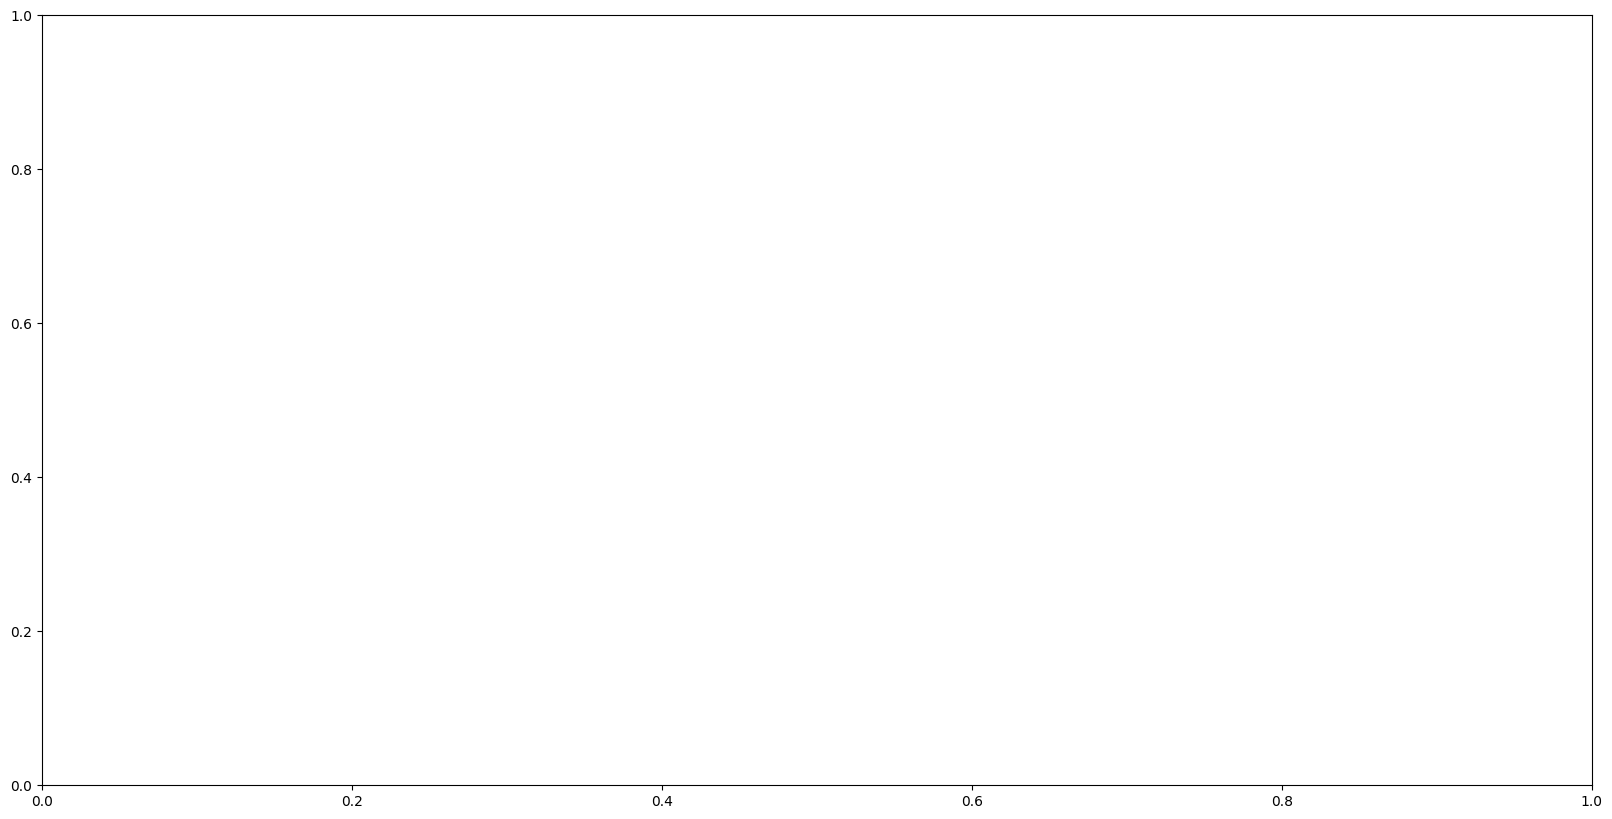

In [10]:
# --- 1. Prepare Image List ---
image_pairs = []
if img_list and len(img_list) > 0:
    if len(img_list) % 2 != 0:
        raise ValueError("Error: img_list must have an even number of arguments.")
    for i in range(0, len(img_list), 2):
        image_pairs.append((img_list[i], img_list[i+1]))
elif img_file and os.path.exists(img_file):
    with open(img_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                image_pairs.append((parts[0].strip(), parts[1].strip()))
else:
    raise ValueError("Error: Must provide valid img_list or img_file path.")

print(f"Found {len(image_pairs)} pairs to process.")
print("Using Pure OpenCV/NumPy SIFT Pipeline...")

est_method_flag = cv2.LMEDS if method == 'LMEDS' else cv2.RANSAC

# Prepare output directory
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = f"output/SIFT_Standalone_Jupyter_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

csv_rows = []

# --- 2. Run Inference Loop ---
for i, (src_path, tgt_path) in enumerate(tqdm(image_pairs, desc="Processing Pairs")):
    try:
        src_gray, src_rgb = load_and_preprocess(src_path, image_size)
        tgt_gray, tgt_rgb = load_and_preprocess(tgt_path, image_size)
    except Exception as e:
        print(f"Skip pair {i} due to error: {e}")
        continue

    # Extract and match points using SIFT
    m1, m2, heatmap1, heatmap2 = run_sift_match(src_gray, tgt_gray, nn_threshold)

    prefix = f"pair_{i:03d}_{os.path.basename(src_path).split('.')[0]}"
    text_log = "SIFT Failed"
    
    M_est = None
    warped_src_rgb = None
    m1_trans_plot = None

    # Estimate affine transformation matrix
    if len(m1) >= 3:
        M_est, inliers = cv2.estimateAffinePartial2D(m1, m2, method=est_method_flag)

    if M_est is not None:
        warped_src_rgb = cv2.warpAffine(src_rgb, M_est, (image_size, image_size))
        
        is_bad, reason = check_transform_validity(warped_src_rgb, M_est)
        if not is_bad:
            inl_cnt = int(np.sum(inliers))
            text_log = f"SIFT Win (Inliers:{inl_cnt}/{len(m1)})"
            m1_trans_plot = cv2.transform(m1.reshape(-1, 1, 2), M_est).reshape(-1, 2).T
        else:
            text_log = f"Bad Transform: {reason}"

    # Prepare plot points
    m1_plot = m1.T if len(m1) > 0 else None
    m2_plot = m2.T if len(m2) > 0 else None

    # --- 3. Plot color results using DL_affine_plot_color ---
    # The function saves the image automatically to the output_dir
    DL_affine_plot_color(prefix, output_dir,
                   "Result", text_log, src_rgb, tgt_rgb,
                   warped_src_rgb if warped_src_rgb is not None else src_rgb,
                   m1_plot, m2_plot, m1_trans_plot,
                   None, None,
                   affine_params_true=None,
                   affine_params_predict=M_est, 
                   heatmap1=heatmap1, heatmap2=heatmap2, plot=1)

    # --- 4. Save individual color images and prepare CSV data ---
    csv_src_path = src_path
    csv_tgt_path = tgt_path
    csv_warp_path = ""

    if save_images == 1:
        save_src = os.path.join(output_dir, f"{prefix}_src.png")
        save_tgt = os.path.join(output_dir, f"{prefix}_tgt.png")
        
        cv2.imwrite(save_src, cv2.cvtColor(src_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(save_tgt, cv2.cvtColor(tgt_rgb, cv2.COLOR_RGB2BGR))
        
        csv_src_path = save_src
        csv_tgt_path = save_tgt

        if warped_src_rgb is not None:
            save_warp = os.path.join(output_dir, f"{prefix}_warp.png")
            cv2.imwrite(save_warp, cv2.cvtColor(warped_src_rgb, cv2.COLOR_RGB2BGR))
            csv_warp_path = save_warp

    csv_rows.append([i, csv_src_path, csv_tgt_path, csv_warp_path, len(m1), text_log])

# --- 5. Generate CSV file ---
csv_file_path = os.path.join(output_dir, "results_log.csv")
with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['index', 'source', 'target', 'warped', 'num_matches', 'status'])
    writer.writerows(csv_rows)

print(f"\nFinished processing. Results saved to {output_dir}")
print(f"CSV Log generated at: {csv_file_path}")